<a href="https://colab.research.google.com/github/furk4neg3/TextEmotionRecognition/blob/main/text_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text - Emotion Recognition
✅In this notebook, I've created  AI models that takes text as an input, and predicts the emotion that shown on this text. I've used created 6 models for this. First is baseline model, second is a simple deep learning model, then I've started using RNN. Third model is LSTM, fourth is GRU, fifth is Bidirectional LSTM. And in the last model, I've used transfer learning, embedding layer of this model is Universal Sentence Encoder.

✅Data preparing and preprocessing is all done by me. Dataset is from Kaggle.

## Taking and preparing data

In [2]:
# Preparing the notebook to be able to load the dataset
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()# I've expired the key before uploading the project to GitHub

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"furkanegecannizam","key":"e9bc49a8350007b4f76376de9272a32b"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [6]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [47]:
# Getting the dataset
! kaggle datasets download -d simaanjali/emotion-analysis-based-on-text

Dataset URL: https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text
License(s): CC0-1.0
 66% 21.0M/31.9M [00:00<00:00, 103MB/s] 
100% 31.9M/31.9M [00:00<00:00, 109MB/s]


In [48]:
! unzip /content/emotion-analysis-based-on-text.zip

Archive:  /content/emotion-analysis-based-on-text.zip
  inflating: emotion_sentimen_dataset.csv  


In [50]:
# Taking dataset in a dataframe
import pandas as pd
df = pd.read_csv('/content/emotion_sentimen_dataset.csv', encoding='utf-8')

In [51]:
# Some examples of the data
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [57]:
# Taking sentences and labels
sentences = df['text'].tolist()
labels = df['Emotion'].tolist()

In [61]:
# Examples of sentences and labels, and number of sentences we have
sentences[:5], labels[:5], len(sentences)

(['i seriously hate one subject to death but now i feel reluctant to drop it',
  'im so full of life i feel appalled',
  'i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it',
  'ive been really angry with r and i feel like an idiot for trusting him in the first place',
  'i feel suspicious if there is no one outside like the rapture has happened or something'],
 ['hate', 'neutral', 'neutral', 'anger', 'neutral'],
 839555)

In [63]:
from sklearn.model_selection import train_test_split

# Taking 70% of the data as train data, temp values will be used again
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences,
    labels,
    test_size=0.3,
    stratify=labels
)

# temp values are divided into two part, that way 15% of the data is train data
# and other 15% is test data
val_sentences, test_sentences, val_labels, test_labels = train_test_split(
    temp_sentences,
    temp_labels,
    test_size=0.5,
)

In [64]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder and transform the labels to numerical values
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Get the mapping of labels so we can use it when we want to visualize the
# prediction of a model
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}


In [65]:
# Put our data in TensorFlow dataset to prefetch them later
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_encoded))

In [66]:
# Define batch size
BATCH_SIZE = 32

# Function to shuffle, batch and prefetch the data. That way, model will train
# faster and more accurately
def prepare_dataset(dataset, batch_size=BATCH_SIZE):
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=1000)

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    # Prefetch the dataset
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Prepare the datasets
train_data = prepare_dataset(train_dataset)
val_data = prepare_dataset(val_dataset)
test_data = prepare_dataset(test_dataset)

In [68]:
from tensorflow.keras.layers import TextVectorization

# Create a TextVectorization layer
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int", # Labels will be in
                                    # integer form
                                    output_sequence_length=None)

In [71]:
# Calculate the number of words in each sentence
word_counts = [len(sentence.split()) for sentence in train_sentences]

# Calculate the average word count
average_word_count = sum(word_counts) / len(word_counts)

# Print the average word count
print("Average word count per sentence:", average_word_count)

Average word count per sentence: 19.21753379344142


In [72]:
max_vocab_length = 10000 # Maximum number of words to have in vocabulary
max_length = int(average_word_count) # max_length will be average number of
# words in vocab

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [73]:
text_vectorizer.adapt(train_sentences)# Adapting text vectorizer on train data

In [74]:
from tensorflow.keras import layers

# Create an embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")

embedding

## Model 0: Baseline Model

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create baseline model
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the baseline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [76]:
# Calculate and print accuracy of baseline model, which we'll try to beat later
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model achieves accuracy of: {baseline_score*100:.2f}%")

Baseline model achieves accuracy of: 82.91%


## Model 1: Basic Deep Learning Model

In [80]:
# Most basic deep learning model for this problem for starting small
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(13, activation="sigmoid")(x)# Because we have 13 classes
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [81]:
# Compile the first deep learning model
model_1.compile(loss="sparse_categorical_crossentropy",# because labels are in
                # integer form, loss is sparse categorical crossentropy
                optimizer=tf.keras.optimizers.Adam(),# Using Adam as optimizer
                # because it's safe
                metrics=["accuracy"])# using accuracy as metric because it's
                # easy to understand

❗As described in the code, epoch numbers are not consistent. Reason of this is that I have limited time and processing units on Google Colab. I know that it's not fair to use different epochs for different models, but I've tried to fit them long enough for them to learn. Other than that, it mostly depends on the time that they take.

In [83]:
# Fit the first deep learning model
model_1_history = model_1.fit(train_data,
                              epochs=5,# Even if I've prefetched the data,
                              # there's so many training data so epochs are
                              # chosen how long they take (not fair, I know,
                              # but I have limited time and processing unit on
                              # colab)
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_1_dense",
                                            verbose=0,
                                            save_best_only=True)])# Save only
                                            # the best model for better results

Epoch 1/5
18366/18366 [==============================] - 135s 7ms/step - loss: 0.2463 - accuracy: 0.9539 - val_loss: 0.2116 - val_accuracy: 0.9604
Epoch 2/5
18366/18366 [==============================] - 138s 8ms/step - loss: 0.1917 - accuracy: 0.9612 - val_loss: 0.2034 - val_accuracy: 0.9620
Epoch 3/5
18366/18366 [==============================] - 139s 8ms/step - loss: 0.1775 - accuracy: 0.9624 - val_loss: 0.2013 - val_accuracy: 0.9625
Epoch 4/5
18366/18366 [==============================] - 140s 8ms/step - loss: 0.1702 - accuracy: 0.9632 - val_loss: 0.1997 - val_accuracy: 0.9627
Epoch 5/5
18366/18366 [==============================] - 139s 8ms/step - loss: 0.1659 - accuracy: 0.9637 - val_loss: 0.1990 - val_accuracy: 0.9627


In [127]:
# Take the model that saved, which is the one with highest accuracy. Then
# calculate and save the results to compare with other models later.
model_1 = tf.keras.models.load_model("/content/model_1_dense")
model_1_results = model_1.evaluate(test_data)

3936/3936 [==============================] - 7s 2ms/step - loss: 0.2027 - accuracy: 0.9623


## Model 2: LSTM

In [88]:
# Create a new embedding layer, which is the same as the old one. Will do that
# in every model that use our own embedding layer. Because if we use the same
# embedding layer in a later model, it will use learned weights and it won't
# be fair.
model_2_embeddings = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_2")

# Create the second deep learning model. That's our first RNN model and we use
# LSTM and dense layer.
inputs = layers.Input((1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embeddings(x)
x = layers.LSTM(256, return_sequences=True)(x)# If return_sequences isn't True,
# another LSTM layer can't be used.
x = layers.LSTM(256)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(13, activation="sigmoid")(x)# Because we have 13 classes

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compiling and fitting the model is the same as model_1
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2_history = model_2.fit(train_data,
                              epochs=2,# Epochs is set to 2 because RNN models
                              # take longer to train then dense model.
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=model_2.name,
                                            verbose=0,
                                            save_best_only=True)])

Epoch 1/2
18366/18366 [==============================] - 1296s 70ms/step - loss: 0.2615 - accuracy: 0.9490 - val_loss: 0.2076 - val_accuracy: 0.9618
Epoch 2/2
18366/18366 [==============================] - 1290s 70ms/step - loss: 0.1982 - accuracy: 0.9616 - val_loss: 0.1996 - val_accuracy: 0.9624


In [128]:
# Take the model that saved, which is the one with highest accuracy. Then
# calculate and save the results to compare with other models later.
model_2 = tf.keras.models.load_model("/content/model_2_LSTM")
model_2_results = model_2.evaluate(test_data)

3936/3936 [==============================] - 103s 26ms/step - loss: 0.2031 - accuracy: 0.9619


## Model 3: GRU

In [91]:
# Create a new embedding layer, which is the same as the old one. Will do that
# in every model that use our own embedding layer. Because if we use the same
# embedding layer in a later model, it will use learned weights and it won't
# be fair.
model_3_embeddings = layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer="uniform",
                                      input_length=max_length,
                                      name="embedding_3")

# Third model is focused on GRU layers.
inputs = layers.Input((1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embeddings(x)
x = layers.GRU(256, return_sequences=True)(x)# Like LSTM, if return_sequences
# isn't set to True, GRU layers can't be stacked
x = layers.GRU(256)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(13, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

# Compiling and fitting the model is the same as model_1
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_history = model_3.fit(train_data,
                              epochs=2,# Epochs is set to 2 because RNN models
                              # take longer to train then dense model.
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=model_3.name,
                                                                            verbose=0,
                                                                            save_best_only=True)])

Epoch 1/2
18366/18366 [==============================] - 1061s 58ms/step - loss: 0.2419 - accuracy: 0.9549 - val_loss: 0.2084 - val_accuracy: 0.9622
Epoch 2/2
18366/18366 [==============================] - 1059s 58ms/step - loss: 0.2017 - accuracy: 0.9616 - val_loss: 0.2016 - val_accuracy: 0.9623


In [129]:
# Take the model that saved, which is the one with highest accuracy. Then
# calculate and save the results to compare with other models later.
model_3 = tf.keras.models.load_model("/content/model_3_GRU")
model_3_results = model_3.evaluate(test_data)

3936/3936 [==============================] - 79s 20ms/step - loss: 0.2049 - accuracy: 0.9619


##Model 4: Bidirectional LSTM

In [94]:
# Create a new embedding layer, which is the same as the old one. Will do that
# in every model that use our own embedding layer. Because if we use the same
# embedding layer in a later model, it will use learned weights and it won't
# be fair.
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer="uniform",
                                      input_length=max_length,
                                      name="embedding_4")

# Fourth model is focused on Bidirecional layer. If we take a look, we can see
# that LSTM model performed slightly better than GRU model. That's why I've
# used LSTM layer for Bidirectional model. Normally I use 2 RNN layers, but
# bidirectional layers goes and comes back from the layer so I've used 1.
inputs = layers.Input((1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(256))(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(13, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

# Compiling and fitting the model is the same as model_1
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4_history = model_4.fit(train_data,
                              epochs=2,# Epochs is set to 2 because RNN models
                              # take longer to train then dense model.
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=model_4.name,
                                                                            verbose=0,
                                                                            save_best_only=True)])

Epoch 1/2
18366/18366 [==============================] - 796s 43ms/step - loss: 0.2543 - accuracy: 0.9502 - val_loss: 0.2056 - val_accuracy: 0.9618
Epoch 2/2
18366/18366 [==============================] - 791s 43ms/step - loss: 0.1882 - accuracy: 0.9623 - val_loss: 0.1939 - val_accuracy: 0.9626


In [130]:
# Take the model that saved, which is the one with highest accuracy. Then
# calculate and save the results to compare with other models later.
model_4 = tf.keras.models.load_model("/content/model_4_bidirectional")
model_4_results = model_4.evaluate(test_data)

3936/3936 [==============================] - 59s 15ms/step - loss: 0.1968 - accuracy: 0.9620


## Model 5: Transfer Learning

In [122]:
# This model is different from the others. We will use transfer learning,
# encoding sentences is done with a pretrained model, Universal Sentence
# Encoder.
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

# Get Universal Sentence Encoder as TensorFlow layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="UniversalSentenceEncoder")

# Create the model with pretrained sentence enccoder. I've used Bidirectional
# layer with it, because it's the best performing one so far.
inputs = layers.Input((), dtype="string")
x = sentence_encoder_layer(inputs)
# Reshape the output to be 3D for the LSTM layer
x = tf.expand_dims(x, axis=1)
x = layers.Bidirectional(layers.LSTM(256))(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(13, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_tinybert")

# Compiling and fitting the model is the same as model_1
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5_history = model_5.fit(train_data,
                              epochs=8,# Epochs is set to 8, because it takes
                              # less time to train per epoch. That's because
                              # encoding layer isn't learning (trainable=False).
                              validation_data=val_data,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=model_5.name,
                                                                            verbose=0,
                                                                            save_best_only=True)])

Epoch 1/8
18366/18366 [==============================] - 304s 16ms/step - loss: 0.4112 - accuracy: 0.8799 - val_loss: 0.3430 - val_accuracy: 0.8963
Epoch 2/8
18366/18366 [==============================] - 298s 16ms/step - loss: 0.3050 - accuracy: 0.9070 - val_loss: 0.2957 - val_accuracy: 0.9101
Epoch 3/8
18366/18366 [==============================] - 301s 16ms/step - loss: 0.2439 - accuracy: 0.9245 - val_loss: 0.2612 - val_accuracy: 0.9209
Epoch 4/8
18366/18366 [==============================] - 296s 16ms/step - loss: 0.1894 - accuracy: 0.9411 - val_loss: 0.2397 - val_accuracy: 0.9307
Epoch 5/8
18366/18366 [==============================] - 297s 16ms/step - loss: 0.1423 - accuracy: 0.9563 - val_loss: 0.2224 - val_accuracy: 0.9377
Epoch 6/8
18366/18366 [==============================] - 282s 15ms/step - loss: 0.1045 - accuracy: 0.9681 - val_loss: 0.2245 - val_accuracy: 0.9425
Epoch 7/8
18366/18366 [==============================] - 282s 15ms/step - loss: 0.0754 - accuracy: 0.9773 - val_

In [124]:
# Take the model that saved, which is the one with highest accuracy. Then
# calculate and save the results to compare with other models later.
model_5 = tf.keras.models.load_model("/content/model_5_tinybert")
model_5_results = model_5.evaluate(test_data)

3936/3936 [==============================] - 35s 8ms/step - loss: 0.2247 - accuracy: 0.9374


[0.2246769219636917, 0.9374037384986877]

## Visualizing the performance of the models

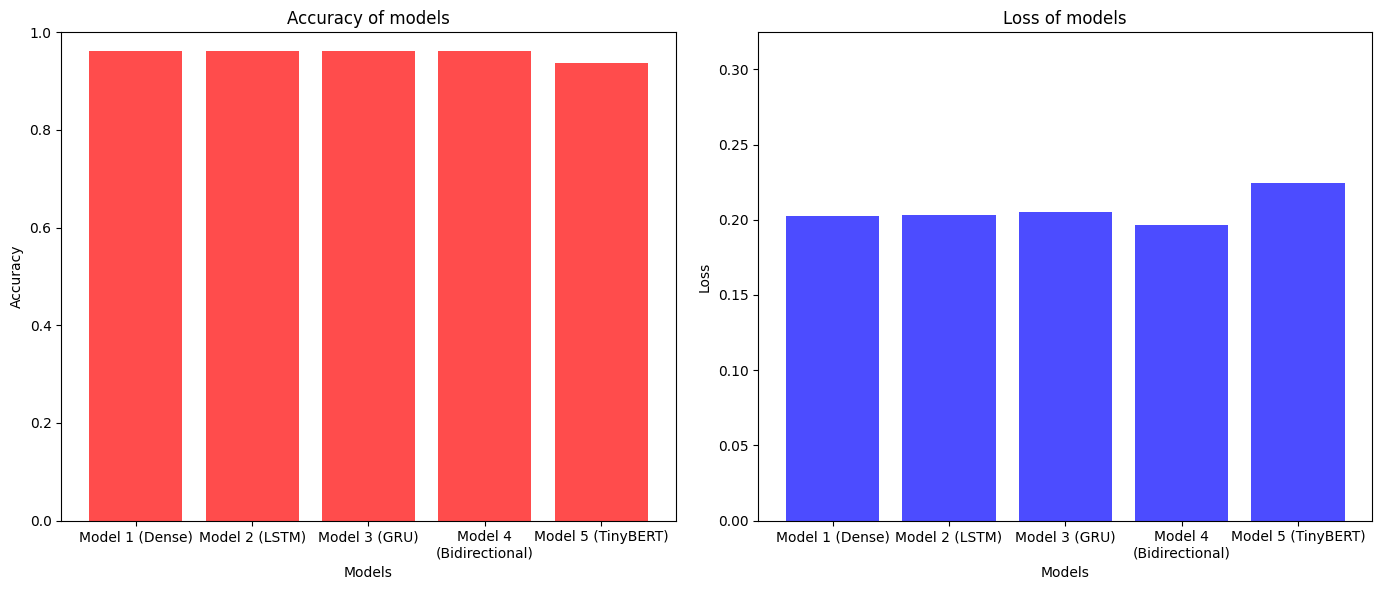

In [150]:
# Visualize loss and accuracy parameters.
import matplotlib.pyplot as plt

# Name the models.
models = ["Model 1 (Dense)", "Model 2 (LSTM)", "Model 3 (GRU)", "Model 4\n(Bidirectional)", "Model 5 (TinyBERT)"]
x = range(len(models))# X-axis positions

# Use evaluated loss and accuracies to visualize.
losses = [model_1_results[0], model_2_results[0], model_3_results[0], model_4_results[0], model_5_results[0]]
accuracies = [model_1_results[1], model_2_results[1], model_3_results[1], model_4_results[1], model_5_results[1]]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot models
axs[0].bar(models, accuracies, color='r', alpha=0.7)
axs[0].set_xlabel('Models')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy of models')
axs[0].set_ylim(0, 1)# Accuracy ranges from 0 to 1

# Plot losses
axs[1].bar(models, losses, color='b', alpha=0.7)
axs[1].set_xlabel('Models')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss of models')
axs[1].set_ylim(0, max(losses) + 0.1)# Adjust y-axis limit to fit the data

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

## Example usage on an example sentence

In [148]:
# Example of how model predicts the emotion of a sentence.
example_sentence = "Could it be that you love me?"# I've used a message that my
# girlfriend sent me as an example.
prediction = model_4.predict([example_sentence])# It can be seen that model_4
# is the best among those models, that's why I'm using it to make a prediction.
predicted_class_index = tf.argmax(prediction, axis=1)[0]# get the predicted
# label in numerical form.
index_to_label = {v: k for k, v in label_mapping.items()}# When encoding labels,
# I said that we'll use the dictionary later. That's where we're using it.
predicted_label = index_to_label[predicted_class_index.numpy()]# Get the
# predicted class.
print(f"The predicted label for the sentence is: {predicted_label}")# Print the
# predicted class. As you can see, model works fine, it predicted right
# emotion.

1/1 [==============================] - 0s 56ms/step
The predicted label for the sentence is: love
